In [7]:
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node 64e55146-4396-4fc6-92de-f57708205244

In [8]:
#librairy for kalman
#!pip install filterpy 
#!pip install tqdm
#!pip install pyvisgraph
#!pip install opencv-python
#!pip install opencv-contrib-python --user

In [9]:
#pip install scipy

In [22]:
import numpy as np
import cv2
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from scipy import ndimage
import math

In [23]:
global speed_right, speed_left, direction,robot_state,state,new_image,index,obst, qp, rp, q_nu, r_nu, dt,frame,shortest_path
speed_left=0
speed_right=0
timer_cam=1
dt=0.1
state=0
new_image=0
direction=0
robot_state=np.array([0,0,0,0],'double') # [x,y,vx,vy]
pos_cam=np.array([0,0],'double')
Ts = 0.1
qp = 0.6 # variance on position state
rp = 0.01 # variance on position measurement
q_nu= 0.1 #variance on speed state
r_nu=0.025 #variance on speed measurement
index=0

In [24]:


class Map:
    # compute_globalmap(self,image,start_id=0,goal_id=1):
    #  Generate globalmap : 0:free 1:occupied
    #  return globalmap
    # avg_globalmap(self, cap, avg_number=10):
    #  average first avg_number image to construct global map instead of only use one image
    #  in order to get rid of camera unstable problem
    #  return self.globalmap
    # add_margin(self,globalmap,robot_size=35):
    #  object inflation, add margin to global map
    #  robot_size: robot_size in mm
    #  return global map with margin
    # compute_pixel_to_distance(self):
    #  compute real world distance between two neighborhood pixels;unit:mm
    #  **only have the value when goal is detected successfully
    #  return self.pixel_to_distance
    # compute_start(self,image, start_id=0):
    #  Detect start by aruco marker
    #  Return start position in (x,y) coordinate; if not detected return None
    #  return self.start
    # compute_goal(self,image, goal_id=1):
    #  Detect goal by aruco marker
    #  Return goal position in (x,y) coordinate; if not detected return None
    #  return self.goal
    # get_pixel_to_distance(self):
    #  return self.pixel_to_distance
    # get_globalmap(self):
    #  return self.globalmap
    # get_start(self):
    #  return self.start
    # get_goal(self):
    #  return self.goal
    # get_start_distance(self):
    #  get the center point of start point in mm
    #  return start
    # get_goal_distance(self):
    #  get the center point of start point in mm
    #  return goal
    # transfer_to_distance(self,data):
    # Transfer data from pixel to real-world distance
    #return data in mm

    def compute_globalmap(self, image, start_id=0, goal_id=1):
        # Generate globalmap : 0:free 1:occupied
        height, width = image.shape[:2]

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Simple threshold method
        # ret,thresh = cv2.threshold(gray,50,255,cv2.THRESH_BINARY)


        # Otsu's thresholding after Gaussian filtering
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        ret, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        # cv2.imshow("thresh", thresh)

        # Generate Global map
        # from 0,255 convert to 0(free),1(occupied);change to (x,y) coordinate
        temp_globalmap = np.transpose(np.array(thresh < 255, dtype=int))

        # Detect start and goal by aruco marker
        # Return start and goal position in (x,y) coordinate; if not detected return None
        # start_id: start aruco marker id
        # goal_id=: goal aruco marker id

        # Define aruco marker detector
        arucoDict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_50)
        arucoParams = cv2.aruco.DetectorParameters_create()

        # Detect aruco marker
        (corners, ids, rejected) = cv2.aruco.detectMarkers(image, arucoDict, parameters=arucoParams)
        # print(corners, ids, rejected)
        start = None
        goal = None
        s = 10
        if ids is not None:
            for corner, number in zip(corners, ids):
                (topLeft, topRight, bottomRight, bottomLeft) = corner[0].astype(int)
                # print(topLeft, topRight, bottomRight, bottomLeft)
                centerpoint = ((topLeft[0] + bottomRight[0]) / 2, (topLeft[1] + bottomRight[1]) / 2)
                side_length=math.dist(topLeft, topRight)/2
                self.side_length=side_length
                if number == start_id:
                    start = centerpoint
                    print("start:",start)
                    # print(topLeft, topRight, bottomRight, bottomLeft)
                    #temp_globalmap[topLeft[0] - s:bottomRight[0] + s, topLeft[1] - s:bottomRight[1] + s] = 0
                    x_small=int(centerpoint[0]-side_length)-s
                    x_large=int(centerpoint[0]+side_length)+s
                    y_small =int(centerpoint[1]-side_length)-s
                    y_large=int(centerpoint[1]+side_length)+s
                    if x_small<0: x_small=0
                    if y_small<0:y_small=0
                    if x_large>=width:x_large=width-1
                    if y_large>=height:y_large=height-1
                    temp_globalmap[x_small:x_large,y_small:y_large] = 0
                    # print(temp_globalmap[bottomRight[0]-2:topLeft[0]+2,topLeft[1]-2:bottomRight[1]+2])

                elif number == goal_id:
                    goal = centerpoint
                    print("goal:",goal)
                    # print(topLeft, topRight, bottomRight, bottomLeft)
                    #temp_globalmap[topLeft[0] - s:bottomRight[0] + s, topLeft[1] - s:bottomRight[1] + s] = 0
                    x_small = int(centerpoint[0] - side_length) - s
                    x_large = int(centerpoint[0] + side_length) + s
                    y_small = int(centerpoint[1] - side_length) - s
                    y_large = int(centerpoint[1] + side_length) + s
                    if x_small < 0: x_small = 0
                    if y_small < 0: y_small = 0
                    if x_large >= width: x_large = width - 1
                    if y_large >= height: y_large = height - 1
                    temp_globalmap[x_small:x_large, y_small:y_large] = 0
                    # print(temp_globalmap[bottomRight[0]-2:topLeft[0]+2,topLeft[1]-2:bottomRight[1]+2])
                    # self.goal_topLeft=topLeft
                    # self.goal_topRight=topRight
                else:
                    x_small = int(centerpoint[0] - side_length) - s
                    x_large = int(centerpoint[0] + side_length) + s
                    y_small = int(centerpoint[1] - side_length) - s
                    y_large = int(centerpoint[1] + side_length) + s
                    if x_small < 0: x_small = 0
                    if y_small < 0: y_small = 0
                    if x_large >= width: x_large = width - 1
                    if y_large >= height: y_large = height - 1
                    temp_globalmap[x_small:x_large, y_small:y_large] = 0
        else:
            pass

        globalmap = temp_globalmap.copy()

        if start is None:
            print("NOT detect start point")


        else:
            #globalmap[temp_globalmap == 2] = 0
            self.start = start
        if goal is None:
            print("NOT detect goal point")

        else:
            #globalmap[temp_globalmap == 3] = 0
            self.goal = goal



        return globalmap

    def avg_globalmap(self,cap,avg_number=10):
        #average first avg_number image to construct global map instead of only use one image
        #in order to get rid of camera unstable problem
        #return self.globalmap
        weight = cap.get(3)
        height=cap.get(4)
        avg_map = np.zeros((int(weight), int(height)))
        for i in range(avg_number):
            ret, img = cap.read()  # returns ret and the frame
            globalmap = self.compute_globalmap(img)
            avg_map = np.add(globalmap, avg_map)
        avg_map = np.divide(avg_map, avg_number)
        avg_map[avg_map >= 0.5] = 1
        avg_map[avg_map < 0.5] = 0
        self.globalmap= avg_map
        return self.globalmap

    def add_margin(self,globalmap,robot_size=40):
       #object inflation, add margin to global map
       #robot_size: robot_size in mm
       #return global map with margin

        # Compute pixel to distance value
        pixel_to_distance = self.compute_pixel_to_distance()
        print("pixel_to_distance:", pixel_to_distance)

        # obstacle inflation
        # 3x3 structuring element with connectivity 2
        struct = ndimage.generate_binary_structure(2, 2)
        # robot_size:radius of robot(unit:mm)
        margin = int(robot_size / pixel_to_distance) + 1  # margin at least need to be 1, can't be 0
        globalmap = ndimage.binary_dilation(globalmap, structure=struct, iterations=margin).astype(globalmap.dtype)

        # # add start and goal
        # globalmap[temp_globalmap == 2] = 2
        # globalmap[temp_globalmap == 3] = 3
        self.globalmap = globalmap

        return self.globalmap

    def compute_pixel_to_distance(self):
        # for get pixel_to_ditance value, use function "get_pixel_to_distance"
        # aruco marker:71mmx71mm
        # pixel_to_distance:return real world distance between two neighborhood pixels;unit:mm
        #pixel_to_distance = 71 / math.dist(self.goal_topLeft, self.goal_topRight)  # unit:mm
        pixel_to_distance = 71 / (self.side_length*2)  # unit:mm
        #print("Distance between two pixel is:", pixel_to_distance, "mm")

        self.pixel_to_distance = pixel_to_distance

        return self.pixel_to_distance

    def get_pixel_to_distance(self):
        return self.pixel_to_distance

    def get_globalmap(self):
        return self.globalmap

    def get_start(self):
        # get the center point of start point
        if self.start is None:
            print("NOT detect start point")
        else:
            pass
        return self.start

    def get_start_distance(self):
        # get the center point of start point in mm
        if self.start is None:
            print("NOT detect start point")
        else:
            pass
        start = np.multiply(self.start , self.pixel_to_distance)
        return start

    def get_goal(self):
        # get the center point of goal point
        if self.goal is None:
            print("NOT detect goal point")
        else:
            pass

        return self.goal

    def get_goal_distance(self):
        # get the center point of start point in mm
        if self.goal is None:
            print("NOT detect start point")
        else:
            pass
        goal = np.multiply(self.goal,self.pixel_to_distance)
        return goal

    def transfer_to_distance(self,data):
        # Transfer from pixel to real-world distance
        return np.multiply(data,self.pixel_to_distance)


    def compute_start(self, image, start_id=0):
        # Detect start by aruco marker
        # Return start position in (x,y) coordinate; if not detected return None
        # start_id: start aruco marker id

        # Define aruco marker detector
        arucoDict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_50)
        arucoParams = cv2.aruco.DetectorParameters_create()

        # Detect aruco marker
        (corners, ids, rejected) = cv2.aruco.detectMarkers(image, arucoDict, parameters=arucoParams)
        # print(corners, ids, rejected)
        start = None
        if ids is not None:
            for corner, number in zip(corners, ids):
                (topLeft, topRight, bottomRight, bottomLeft) = corner[0].astype(int)
                # print(topLeft, topRight, bottomRight, bottomLeft)
                centerpoint = ((topLeft[0] + bottomRight[0]) / 2, (topLeft[1] + bottomRight[1]) / 2)
                if number == start_id:
                    start = centerpoint
                    break
                else:
                    pass
        else:
            pass
        if start is None:
            print("NOT detect start point")
        else:
            print("start position is:", start)
        self.start = start

        return self.start


    def compute_goal(self, image, goal_id=1):
        # Detect goal by aruco marker
        # Return goal position in (x,y) coordinate; if not detected return None
        # goal_id=: goal aruco marker id

        # Define aruco marker detector
        arucoDict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_50)
        arucoParams = cv2.aruco.DetectorParameters_create()

        # Detect aruco marker
        (corners, ids, rejected) = cv2.aruco.detectMarkers(image, arucoDict, parameters=arucoParams)
        # print(corners, ids, rejected)
        goal = None
        if ids is not None:
            for corner, number in zip(corners, ids):
                (topLeft, topRight, bottomRight, bottomLeft) = corner[0].astype(int)
                # print(topLeft, topRight, bottomRight, bottomLeft)
                centerpoint = ((topLeft[0] + bottomRight[0]) / 2, (topLeft[1] + bottomRight[1]) / 2)
                if number == goal_id:
                    goal = centerpoint
                    # self.goal_topLeft = topLeft
                    # self.goal_topRight = topRight
                    break
                else:
                    pass
        else:
            pass
        if goal is None:
            print("NOT detect goal point")
        else:
            print("goal position is:", goal)
        self.goal = goal

        return self.goal



     


In [25]:
def compute_vertex(globalmap):
    # # get rid of start and goal area
    # globalmap[globalmap == 2] = 0
    # globalmap[globalmap == 3] = 0

    globalmap = np.uint8(np.dot(np.transpose(globalmap), 255))

    # apply canny edge detection
    edges = cv2.Canny(globalmap, 60, 160)

    # apply morphology close
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    morph = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    # get contours
    contours = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # get vertices
    vertices = []
    for i in range(len(contours[0])):
        peri = cv2.arcLength(contours[0][i], True)
        approx = cv2.approxPolyDP(contours[0][i], 0.01 * peri, True)
        vertice = []
        for i in range(len(approx)):
            vertice.append(approx[i][0].tolist())
        vertices.append(np.array(vertice))

    return vertices

In [26]:
def get_robot_position(image,robot_id=0):
    #Detect robot position by aruco marker
    #Return robot position; if not detected return None
    #robot_id: robot aruco marker id

    #Define aruco marker detector
    arucoDict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_50)
    arucoParams = cv2.aruco.DetectorParameters_create()

    robot_position = None
    angle=None

    #Detect Aruco marker
    (corners, ids, rejected) = cv2.aruco.detectMarkers(image, arucoDict,parameters=arucoParams)
    # print(corners, ids, rejected)
    if ids is not None:
        #print("aruco marker detected:",ids)
        for corner,number in zip(corners,ids):
            (topLeft, topRight, bottomRight, bottomLeft) = corner[0]
            centerpoint=(int((topLeft[0]+bottomRight[0])/2),int((topLeft[1]+bottomRight[1])/2))
            if number==robot_id:
                robot_position=centerpoint
                angle=angle_calculate(topRight,topLeft)
                break
            else:pass
    else:pass
    print("angle",angle)
    return robot_position,angle

def angle_calculate(pt1,pt2):  # function which returns angle between two points in the range of 0-359
    #angle_list = list(range(0,360,1))
    x=pt2[0]-pt1[0] 
    y=pt2[1]-pt1[1]
    angle=np.arctan2(y,x) #takes 2 points nad give angle with respect to horizontal axis in range(-180,180)
    return angle

In [27]:
def kalman(current_state, motor_speed, image):
    global new_image,direction,dt
    #estimate x-y position with velocity
    #measurements and camera postion measurement
    f = KalmanFilter (dim_x=4, dim_z=4)

    # initial position
    f.x= np.transpose(current_state)
    print(np.dot(f.F,f.x))
    
    #state transition matrix
   
    f.F = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt], 
              [0, 0, 1, 0],
              [0, 0, 0, 1]])

    #measurement function H
    f.H = np.array([[1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1]])

    #covariance matrix P
    f.P = np.array([[qp, 0, 0, 0], 
              [0, qp, 0, 0], 
              [0, 0, q_nu, 0], 
              [0, 0, 0, q_nu]])

    #measurement noise R (scalar)
    f.R = np.array([[rp, 0, 0, 0],
                [0, rp, 0, 0],
                [0, 0, r_nu, 0],
                [0, 0, 0, r_nu]])

    #process noise Q
    f.Q = Q_discrete_white_noise(dim=4, dt=0.1, var=0.13)
    predicted=np.dot(f.F,f.x)
    pos_cam_temp,direction_temp=get_robot_position(image)
    if(new_image)&(direction_temp!=None): #if image is up to date, take position from camera
        #print(motor_speed)
        #print(pos_cam)
        #new_image=0
        print("camera+motors")
        print("prediction",predicted)
        pos_cam=pos_cam_temp
        direction=direction_temp
        z = np.transpose(np.array([pos_cam[0],pos_cam[1], motor_speed[0],motor_speed[1]]))
        print("measurements",z)
    else:
    #pos=np.array([) #if image outdated, use state position instead of camera position
        
        print("only motors")
        #z = np.array([predicted[0], predicted[1], motor_speed[0],motor_speed[1]])
        z = np.array([current_state[0], current_state[1], motor_speed[0],motor_speed[1]])
        direction=direction+(speed_left-speed_right)*dt/(2*94)
    
    f.predict()
    f.update(z)
    print("output",f.x)
    #return state and covariance matrix
    return f.x

In [28]:
#global path

def global_path(start_pos, goal_pos, global_map):

    import pyvisgraph as vg
    import numpy as np
    import matplotlib.pyplot as plt

    start = np.array(start_pos)#np.array([0.5,0.5])
    goal = np.array(goal_pos)#np.array([5.25,6])

    start_point = vg.Point(start[0], start[1])
    goal_point = vg.Point(goal[0], goal[1])

    vertices = np.array(global_map)#np.array([[[1,2],[3,2],[3,4],[1,4]],[[4,4],[6,4],[5,5]]])
   

    vertices = np.asarray(vertices)
    #print(vertices)

    #plt.plot(vertices)
    #plt.show

    # Automate the creation of vg.Points for the obstacles

    max_vertices = 0

    for i in range(len(vertices)):
        if(len(vertices[i])>max_vertices):
            max_vertices = len(vertices[i])

    polygons = [[0 for i in range(max_vertices+1)] for j in range(len(vertices))]

    for i in range(len(vertices)):
        for j in range(len(vertices[i])):
            polygons[i][j] = vg.Point(vertices[i][j][0],vertices[i][j][1])
        polygons[i][(len(vertices[i])):(max_vertices+1)] = [polygons[i][0] for k in range(len(vertices[i]),max_vertices+1)]
        #polygons[i][range(len(vertices[i]),max_vertices)] = polygons[i][0]
    
    #print(polygons)
    
    graph = vg.VisGraph()
    graph.build(polygons)
    #graph.buffer(margin,join_style=2)

    shortest_path = graph.shortest_path(start_point,goal_point)

    print(shortest_path)

    polygons_x = np.empty((len(polygons),len(polygons[1])+1))
    polygons_y = np.empty((len(polygons),len(polygons[1])+1))

    for i in range(len(polygons)):
        for j in range(len(polygons[i])):
            polygons_x[i][j] = polygons[i][j].x
            polygons_y[i][j] = polygons[i][j].y
        polygons_x[i][len(polygons[1])] = polygons_x[i][0]
        polygons_y[i][len(polygons[1])] = polygons_y[i][0]

    shortest_path_x = np.empty(len(shortest_path))
    shortest_path_y = np.empty(len(shortest_path))
    
    shortest = [[0 for i in range(2)] for j in range(len(shortest_path))]

    for i in range(len(shortest_path)):
        shortest_path_x[i] = shortest_path[i].x
        shortest_path_y[i] = shortest_path[i].y
        shortest[i][0] = shortest_path[i].x
        shortest[i][1] = shortest_path[i].y

    plt.plot(shortest_path_x,shortest_path_y)
    plt.plot(polygons_x.T, polygons_y.T)
    plt.show()
    return shortest
    
    

    


In [29]:
def global_nav(path):
    global state,index,direction,speed_left,speed_right
    
    
    #constantes
    v_max=400#mm/s
    #v_min=20
    Diameter=94#mm
    goal_margin=20#mm
    threshold=0.3
    
    #just to tune by test, names wrong
    Kp_d=0.8
    #CHECK GOAL
  
    
    if math.sqrt((robot_state[0]-path[index][0])**2+(robot_state[1]-path[index][1])**2)<goal_margin:
        if index+1>=int(np.size(path)/2):
            print('arrived')
            state=2
            return 0,0#works only in a function
        else:
            index=index+1
            print('index : ',index)
    print("index",index)
    #MOTORS
    obj_angle=np.arctan2(path[index][1]-robot_state[1],path[index][0]-robot_state[0])
    delta_angle=obj_angle-direction
    while(delta_angle>np.pi):
        delta_angle=obj_angle-np.pi
    while(delta_angle<=-np.pi):
        delta_angle=obj_angle+np.pi
    print( obj_angle)
    if abs(delta_angle)>threshold:
        vitesse=0#-Kd_v*abs(obj_angle-direction[present])+Kp_v*abs(50-vitesse[present])#vitesse[present]
        #if vitesse<0:vitesse=0##v_min
    else:
        vitesse=100#-Ki_v*abs(50-vitesse[present])
    #derror=obj_dir(*position[present,:],*path[goal,:])+obj_dir(*position[present-1,:],*path[goal,:])-direction[present]-direction[present-1]
    speed_left=(Kp_d*(delta_angle))*Diameter#vitesse[present+1]    #0.2*(speed_l[present]+speed_l[present-1])/2    #-Kd_d*derror
    speed_right=-(Kp_d*(delta_angle))*Diameter#vitesse[present+1]    #0.2*(speed_r[present]+speed_r[present-1])/2+    #-Kd_d*derror
    #bounded speed for turn
    if speed_right<-v_max:speed_right=-v_max
    if speed_right>v_max:speed_right=v_max
    if speed_left<-v_max:speed_left=-v_max
    if speed_left>v_max:speed_left=v_max
    #bounded speed for turn+speedDC
    delta_speed=abs(speed_left-speed_right)
    if speed_left+vitesse>v_max:#PB si les deux au dessus
        speed_left=v_max
        speed_right=v_max-delta_speed
    elif speed_right+vitesse>v_max:
        speed_left=v_max-delta_speed
        speed_right=v_max
    else:
        speed_left=speed_left+vitesse
        speed_right=speed_right+vitesse
    #direction=direction+(-speed_right+speed_left)*0.1/(2*Diameter)
    return speed_left,speed_right

In [46]:
def navigation(path, mapvertex, goal):
    global index,speed_left,speed_right,direction,state,shortest_path, robot_state
    #state=1 # 0=gradient, 1=obstacle avoidance
    obstThrL = 1000    
    obstThrH = 20     
    coef = 3

    #goal_nb=0
    #speed_left=0
    #speed_right=0
    #direction=0

    
    #obst = np.array([0,0,0,0,0])  
    #await node.wait_for_variables({"prox.horizontal"})
    obst = list(node.v.prox.horizontal)
    left_obst= (obst[0] + 2*obst[1])//3
    right_obst=(2*obst[3] + obst[4])//3
    if state == 0:
        # if at least one prox sensor above treshold, go into obstacle avoidance (or condition)
        if (obst[0] > obstThrH):
            state = 1
        elif (obst[1] > obstThrH):
            state = 1
        elif (obst[3] > obstThrH):
            state = 1
        elif (obst[4] > obstThrH):
            state = 1
    elif state == 1:
      # if all prox sensors under treshold, go back to global nav (and condition)
        if obst[0] < obstThrL:
            if obst[1] < obstThrL : 
                if obst[3] < obstThrL : 
                    if obst[4] < obstThrL : 
                        state = 0
                        shortest_path=global_path([robot_state[0],robot_state[1]], goal, mapvertex)
                        index=1
                        
    print(obst,'speeds',speed_left,speed_right,state)
    #state=0
    #path=global_path([robot_state[0],robot_state[1]], goal_pos, vertex)           
    if  state  == 0:
        (speed_left, speed_right)=global_nav(path)#,goal_pos)
        motor_left_target = speed_left
        motor_right_target = speed_right
    elif state ==1:
#        leds_top = [30,30,30]
        #motor_left_target = 100 - coef * (right_obst// 100)
       # motor_right_target = 100 + coef * (right_obst// 100)
        
        #motor_right_target = 100 - coef * (left_obst // 100)
       # motor_left_target = 100 + coef * (left_obst // 100)
        
        motor_right_target = 100 - coef * (left_obst // 100)
        motor_left_target = 100 - coef * ( right_obst// 100)
        print("iuygjyg",right_obst,left_obst)
        #shortest_path=global_path([robot_state[0],robot_state[1]], goal_pos, vertex)
        #index=1
    else :
        motor_left_target = 0
        motor_right_target = 0
        
    v = {
            "motor.left.target": [int(motor_left_target*1.5)],
            "motor.right.target": [int(motor_right_target*1.5)],
    }
    aw(node.set_variables(v))
    #await client.sleep(10*dt) # your long-running job goes here... here wait1s

In [47]:
from threading import Timer

class RepeatedTimer(object):
    def __init__(self, interval, function, *args, **kwargs):
        self._timer     = None
        self.interval   = interval
        self.function   = function
        self.args       = args
        self.kwargs     = kwargs
        self.is_running = False
        self.start()

    def _run(self):
        self.is_running = False
        self.start()
        self.function(*self.args, **self.kwargs)

    def start(self):
        if not self.is_running:
            self._timer = Timer(self.interval, self._run)
            self._timer.start()
            self.is_running = True

    def stop(self):
        self._timer.cancel()
        self.is_running = False




In [48]:

#acquire_data = False
#Ts = 0.1
thymio_data = []

def motors(left, right):
    return {
        "motor.left.target": [left],
        "motor.right.target": [right],
    }

def get_data():
    thymio_data.append({"prox":list(node["prox.horizontal"]),#not really useful??
                       "left_speed":node["motor.left.speed"],#for std
                       "right_speed":node["motor.right.speed"]})#for std
    #print("prox/mot")
    
#def get_picture():
    #print(" ")
    #ret, frame = cap.read() #returns ret and the frame
    #pos_cam=get_robot_position(frame) #gets x-y measurements from camera and convert to mm
    #pos_cam[0]=pos_cam[0]*1.6
    #pos_cam[1]=pos_cam[1]*1.6
    #new_image=1


1
2
3
start: (489.5, 233.5)
goal: (89.5, 56.5)
start: (489.5, 234.0)
goal: (89.5, 56.5)
start: (489.5, 234.0)
goal: (90.0, 57.0)
start: (489.0, 234.5)
goal: (89.5, 56.5)
start: (489.5, 233.5)
goal: (89.5, 56.5)
start: (489.5, 234.0)
goal: (89.5, 56.5)


C:\Users\Administrateur\AppData\Local\Temp\ipykernel_6768\1917061359.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  vertices = np.array(global_map)#np.array([[[1,2],[3,2],[3,4],[1,4]],[[4,4],[6,4],[5,5]]])


goal: (89.5, 56.5)
start: (489.5, 233.5)
start: (489.5, 234.0)
goal: (89.5, 56.5)
start: (489.5, 233.5)
goal: (89.5, 56.5)
goal: (89.5, 56.5)
start: (489.5, 233.5)
pixel_to_distance: 1.2805791224068535
4
5
angle 2.9971511


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 149.12it/s]

[Point(489.00, 233.00), Point(418.00, 171.00), Point(245.00, 115.00), Point(89.50, 56.50)]


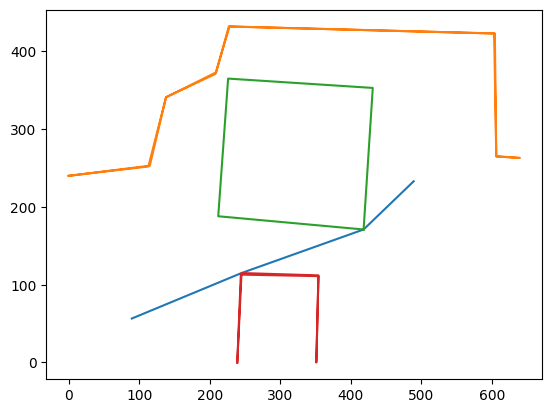

[[489.0, 233.0], [418.0, 171.0], [245.0, 115.0], [89.5, 56.5]]
[ 4.89000000e+02  2.33000000e+02  3.98779918e-07 -3.96360828e-08]
angle 2.9793937
camera+motors
prediction [ 4.89000000e+02  2.33000000e+02  3.98779918e-07 -3.96360828e-08]
measurements [489. 234.  -0.   0.]
output [ 4.89000001e+02  2.33983622e+02 -1.55884305e-04  1.71805072e-03]
[0, 0, 0, 0, 0, 0, 0] speeds 0 0 0
index 1
-2.41595428983433
[ 4.89000001e+02  2.33983622e+02 -1.55884305e-04  1.71805072e-03]
angle 3.0150006
camera+motors
prediction [ 4.88999985e+02  2.33983793e+02 -1.55884305e-04  1.71805072e-03]
measurements [489. 234.  -0.   0.]
output [ 4.89000000e+02  2.33999733e+02 -5.10014049e-05  1.98875878e-04]
[0, 0, 0, 0, 0, 0, 0] speeds 0 0 0
index 1
-2.4158273050665775
[ 4.89000000e+02  2.33999733e+02 -5.10014049e-05  1.98875878e-04]
angle 3.105245
camera+motors
prediction [ 4.88999995e+02  2.33999753e+02 -5.10014049e-05  1.98875878e-04]
measurements [ 4.89000000e+02  2.32000000e+02 -4.95998949e-01  6.31271079e-02]


[ 397.90132604  166.93893725 -129.45677841  -64.17419072]
angle -2.7195876
camera+motors
prediction [ 384.9556482   160.52151818 -129.45677841  -64.17419072]
measurements [ 390.          163.         -135.11431324  -57.90614864]
output [ 389.909547    162.96407173 -133.90730114  -58.57842597]
[0, 0, 0, 0, 0, 0, 0] speeds 132 162 0
index 2
-2.82194971398916
[ 389.909547    162.96407173 -133.90730114  -58.57842597]
angle -2.7540689
camera+motors
prediction [ 376.51881689  157.10622913 -133.90730114  -58.57842597]
measurements [ 386.          161.         -134.1036213   -60.20979658]
output [ 385.84447678  160.9351265  -134.05077245  -60.04574595]
[0, 0, 0, 0, 0, 0, 0] speeds 132 162 0
index 2
-2.8263293108012495
[ 385.84447678  160.9351265  -134.05077245  -60.04574595]
angle -2.7610862
camera+motors
prediction [ 372.43939954  154.9305519  -134.05077245  -60.04574595]
measurements [ 377.          158.         -136.09960449  -55.55085817]
output [ 376.92229848  157.95294842 -135.63130307  

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 124.24it/s]

[Point(287.93, 149.99), Point(89.50, 56.50)]


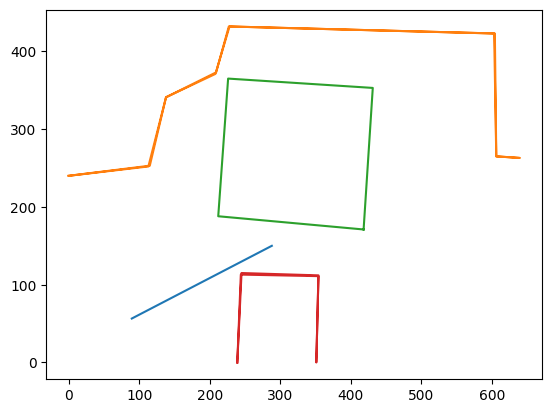

[0, 0, 0, 0, 0, 0, 0] speeds 43 155 0
index 1
0.16012472388193713
[287.92722951 149.99228042 -82.71082526  36.65256095]
angle 2.4227626
camera+motors
prediction [279.65614698 153.65753652 -82.71082526  36.65256095]
measurements [281.         158.         -93.19112465  51.55254123]
output [280.96333866 157.93977175 -90.94782251  49.98369075]
[0, 0, 0, 0, 0, 0, 0] speeds 57 156 0
index 1
-2.6543800523792553
[280.96333866 157.93977175 -90.94782251  49.98369075]
angle 2.1845665
camera+motors
prediction [271.86855641 162.93814083 -90.94782251  49.98369075]
measurements [282.         159.          -9.78349644   8.56056064]
output [281.94254251 159.03098052 -26.34250779  13.4626142 ]
[0, 0, 0, 0, 0, 0, 0] speeds -197 223 0
index 1
-2.6520603827948235
[281.94254251 159.03098052 -26.34250779  13.4626142 ]
angle 2.210566
camera+motors
prediction [279.30829173 160.37724194 -26.34250779  13.4626142 ]
measurements [282.         159.          -7.19942003  10.21853015]
output [281.9810711  159.019136

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 115.65it/s]

[Point(257.93, 152.98), Point(89.50, 56.50)]


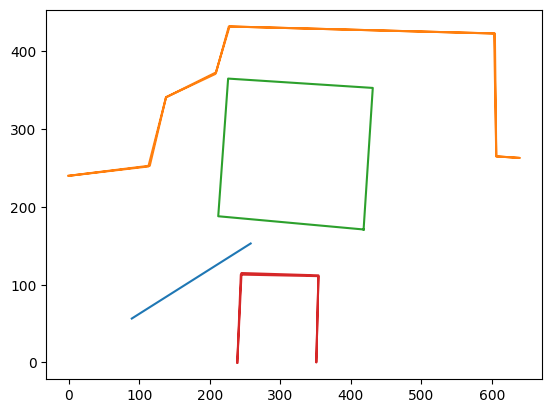

[0, 0, 0, 0, 0, 0, 0] speeds 82 148 0
index 1
-2.6214054002443645
[ 257.92884768  152.97781194 -112.48525789    8.22862785]
angle 2.9889433
camera+motors
prediction [ 246.68032189  153.80067473 -112.48525789    8.22862785]
measurements [ 247.          155.         -124.70345142   14.11736389]
output [ 246.97843965  154.98516629 -122.20832024   13.41438745]
[0, 0, 0, 0, 0, 0, 0] speeds 101 150 0
index 1
-2.582714193640303
[ 246.97843965  154.98516629 -122.20832024   13.41438745]
angle 3.024484
camera+motors
prediction [ 234.75760763  156.32660504 -122.20832024   13.41438745]
measurements [ 246.          155.         -101.3080962    15.58586001]
output [ 245.84288222  155.02192745 -105.41343483   15.58000621]
[0, 0, 0, 0, 0, 0, 0] speeds 99 106 0
index 1
-2.579287272956066
[ 245.84288222  155.02192745 -105.41343483   15.58000621]
angle 3.122727
camera+motors
prediction [ 235.30153874  156.57992807 -105.41343483   15.58000621]
measurements [246.         153.         -16.38698477   1.92788

[ 133.90780033   84.95604575 -125.60379977  -76.89598061]
angle -2.6011732
camera+motors
prediction [ 121.34742035   77.26644768 -125.60379977  -76.89598061]
measurements [ 127.           81.         -126.08490533  -78.45283136]
output [ 126.90684327   80.93781579 -125.98701811  -78.29867671]
[0, 0, 0, 0, 0, 0, 0] speeds 154 143 0
index 1
-2.5629024744416777
[ 126.90684327   80.93781579 -125.98701811  -78.29867671]
angle -2.5849934
camera+motors
prediction [ 114.30814146   73.10794811 -125.98701811  -78.29867671]
measurements [ 120.           77.         -125.62271333  -75.37363324]
output [ 119.90701058   76.93824716 -125.64761379  -75.65266529]
[0, 0, 0, 0, 0, 0, 0] speeds 154 139 0
index 1
-2.5497995329473393
[ 119.90701058   76.93824716 -125.64761379  -75.65266529]
angle -2.5948038
camera+motors
prediction [ 107.3422492    69.37298063 -125.64761379  -75.65266529]
measurements [ 112.           72.         -123.53773552  -76.86792567]
output [ 111.92650315   71.95601125 -123.95569086

In [55]:
import matplotlib.pyplot as plt
my_map=Map()
state=0
index=1
print("1")
cap = cv2.VideoCapture(1) #Resolution (640,480):camera provided in class
print("2")
ret, frame = cap.read() #returns ret and the frame
new_image=0
print("3")
global_map=my_map.avg_globalmap(cap)
global_map=my_map.add_margin(global_map)
print("4")
start_pos=my_map.get_start()
print("5")
robot_start_pos,direction=get_robot_position(frame)

#direction=math.pi
robot_state[0]=robot_start_pos[0]
robot_state[1]=robot_start_pos[1]
goal_pos= my_map.get_goal()
#print("goal:",goal_pos)
vertex= compute_vertex(global_map)
#print("vertex:",vertex)
shortest_path= global_path(robot_start_pos, goal_pos, vertex)
#shortest_path=np.array([[0,0],[0,1000]])
print(shortest_path)
#direction=-np.pi

await node.wait_for_variables()
t1= RepeatedTimer(0.01, get_data)
#t2= RepeatedTimer(1, get_picture)

for i in range(100):#while state!=2: 
    await client.sleep(dt)#timer_cam)#useful??
    ret, frame = cap.read()
    new_image=1
    #obst = list(node.v.prox.horizontal)
    
    #a,b=get_robot_position(frame)
    #print("a,b",a,b)
    #if (pos!=None):
    #    robot_state[0]=pos[0]
    #    robot_state[1]=pos[1]
    #    direction=d1
    #print(obst)
    speed_left=node["motor.left.speed"]
    speed_right=node["motor.right.speed"]
    #speed_left = np.mean([x["left_speed"] for x in thymio_data])#  big list==>std for motors??
    #speed_right = np.mean([x["right_speed"] for x in thymio_data])
    vx=((speed_left+speed_right)/2)*np.cos(direction)
    vy=((speed_left+speed_right)/2)*np.sin(direction)
    motor_speed=np.array([vx,vy])
    robot_state=kalman(robot_state, motor_speed, frame)
    navigation(shortest_path, vertex, goal_pos)
    #print("state", state)
    
    #robot_state=robot_state+[0.5*dt*(speed_left+speed_right)/2*np.cos(direction),0.5*dt*(speed_left+speed_right)/2*np.sin(direction),0,0]
    #direction=direction+(speed_left-speed_right)*dt/(2*94)
    while(direction>np.pi):
        direction=direction-2*np.pi
    while(direction<=-np.pi):
        direction=direction+2*np.pi
    #print(speed_left,speed_right)
    
    #print(robot_state,direction)
t1.stop()
#t2.stop()
v = {
        "motor.left.target": [0],
        "motor.right.target": [0],
    }
aw(node.set_variables(v))

In [ ]:
v = {
        "motor.left.target": [0],
        "motor.right.target": [0],
    }
aw(node.set_variables(v))